In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 1
DATASET_VERSION = "08"

In [4]:
OOF_PATH = Path(f"../data/oof/lgbm-dart-bce-dsv{DATASET_VERSION}")
SUB_PATH = Path(f"../data/subs/lgbm-dart-bce-dsv{DATASET_VERSION}")
ART_PATH = Path(f"../artifacts/lgbm-dart-bce-dsv{DATASET_VERSION}")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
len(input_feats)

1099

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'boosting': 'dart',
    'objective': 'binary',
    'metric': 'None',
    'num_iterations': 4350,
    'num_leaves': 15,
    'learning_rate': 0.05,
    'max_bin': 63,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 1.0,
    'feature_fraction': 0.15,
    'lambda_l1': 5.996099571922015,
    'lambda_l2': 2.8900783163910697,
    'min_data_in_leaf': 1000,
    'path_smooth': 1.476306537276899,
    'min_gain_to_split': 0.313937968985787,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': True,
    'verbosity': -1,
    # dropout params
    'drop_rate': 0.1,
    'max_drop': 40,
    'skip_drop': 0.7,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            free_raw_data=True,
        )
                
        model = lgb.train(
            params=model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [10]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/1 ################################


######################################## training model 1/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.75258	valid_0's recall_at4: 0.604856	valid_0's norm_gini: 0.900305


[100]	valid_0's amex_metric: 0.763675	valid_0's recall_at4: 0.620761	valid_0's norm_gini: 0.90659


[150]	valid_0's amex_metric: 0.769566	valid_0's recall_at4: 0.628797	valid_0's norm_gini: 0.910334


[200]	valid_0's amex_metric: 0.775535	valid_0's recall_at4: 0.637213	valid_0's norm_gini: 0.913858


[250]	valid_0's amex_metric: 0.780662	valid_0's recall_at4: 0.644997	valid_0's norm_gini: 0.916327


[300]	valid_0's amex_metric: 0.784395	valid_0's recall_at4: 0.650888	valid_0's norm_gini: 0.917902


[350]	valid_0's amex_metric: 0.78659	valid_0's recall_at4: 0.65417	valid_0's norm_gini: 0.91901


[400]	valid_0's amex_metric: 0.788351	valid_0's recall_at4: 0.656779	valid_0's norm_gini: 0.919924


[450]	valid_0's amex_metric: 0.789342	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.920642


[500]	valid_0's amex_metric: 0.789696	valid_0's recall_at4: 0.658209	valid_0's norm_gini: 0.921184


[550]	valid_0's amex_metric: 0.790212	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.921626


[600]	valid_0's amex_metric: 0.791098	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.921883


[650]	valid_0's amex_metric: 0.791653	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.922236


[700]	valid_0's amex_metric: 0.792323	valid_0's recall_at4: 0.662122	valid_0's norm_gini: 0.922524


[750]	valid_0's amex_metric: 0.793049	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.922713


[800]	valid_0's amex_metric: 0.793001	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.922911


[850]	valid_0's amex_metric: 0.793518	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.923147


[900]	valid_0's amex_metric: 0.794035	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.923297


[950]	valid_0's amex_metric: 0.794154	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.923492


[1000]	valid_0's amex_metric: 0.794483	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.923687


[1050]	valid_0's amex_metric: 0.794328	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.923882


[1100]	valid_0's amex_metric: 0.794719	valid_0's recall_at4: 0.665404	valid_0's norm_gini: 0.924033


[1150]	valid_0's amex_metric: 0.795713	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.924129


[1200]	valid_0's amex_metric: 0.795925	valid_0's recall_at4: 0.667634	valid_0's norm_gini: 0.924216


[1250]	valid_0's amex_metric: 0.795963	valid_0's recall_at4: 0.667634	valid_0's norm_gini: 0.924291


[1300]	valid_0's amex_metric: 0.795931	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924354


[1350]	valid_0's amex_metric: 0.795977	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.924404


[1400]	valid_0's amex_metric: 0.796003	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924498


[1450]	valid_0's amex_metric: 0.796437	valid_0's recall_at4: 0.668308	valid_0's norm_gini: 0.924565


[1500]	valid_0's amex_metric: 0.7965	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.92465


[1550]	valid_0's amex_metric: 0.796795	valid_0's recall_at4: 0.668855	valid_0's norm_gini: 0.924736


[1600]	valid_0's amex_metric: 0.797047	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.924776


[1650]	valid_0's amex_metric: 0.797001	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.924852


[1700]	valid_0's amex_metric: 0.797169	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.924894


[1750]	valid_0's amex_metric: 0.797136	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.924954


[1800]	valid_0's amex_metric: 0.796958	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.925019


[1850]	valid_0's amex_metric: 0.797244	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.925044


[1900]	valid_0's amex_metric: 0.797696	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.925065


[1950]	valid_0's amex_metric: 0.79727	valid_0's recall_at4: 0.669402	valid_0's norm_gini: 0.925138


[2000]	valid_0's amex_metric: 0.797446	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.925154


[2050]	valid_0's amex_metric: 0.797461	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.925184


[2100]	valid_0's amex_metric: 0.797214	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925236


[2150]	valid_0's amex_metric: 0.797379	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.925273


[2200]	valid_0's amex_metric: 0.797161	valid_0's recall_at4: 0.669023	valid_0's norm_gini: 0.925299


[2250]	valid_0's amex_metric: 0.796837	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925324


[2300]	valid_0's amex_metric: 0.79707	valid_0's recall_at4: 0.668813	valid_0's norm_gini: 0.925328


[2350]	valid_0's amex_metric: 0.79728	valid_0's recall_at4: 0.669233	valid_0's norm_gini: 0.925327


[2400]	valid_0's amex_metric: 0.797751	valid_0's recall_at4: 0.670159	valid_0's norm_gini: 0.925344


[2450]	valid_0's amex_metric: 0.797809	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.925376


[2500]	valid_0's amex_metric: 0.797709	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925386


[2550]	valid_0's amex_metric: 0.797876	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.925383


[2600]	valid_0's amex_metric: 0.797825	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.925406


[2650]	valid_0's amex_metric: 0.797981	valid_0's recall_at4: 0.670538	valid_0's norm_gini: 0.925423


[2700]	valid_0's amex_metric: 0.798074	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.925441


[2750]	valid_0's amex_metric: 0.797622	valid_0's recall_at4: 0.66978	valid_0's norm_gini: 0.925464


[2800]	valid_0's amex_metric: 0.797774	valid_0's recall_at4: 0.670075	valid_0's norm_gini: 0.925473


[2850]	valid_0's amex_metric: 0.797667	valid_0's recall_at4: 0.669865	valid_0's norm_gini: 0.925469


[2900]	valid_0's amex_metric: 0.797529	valid_0's recall_at4: 0.66957	valid_0's norm_gini: 0.925489


[2950]	valid_0's amex_metric: 0.797505	valid_0's recall_at4: 0.669528	valid_0's norm_gini: 0.925483


[3000]	valid_0's amex_metric: 0.797729	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.925509


[3050]	valid_0's amex_metric: 0.797496	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.925506


[3100]	valid_0's amex_metric: 0.797719	valid_0's recall_at4: 0.669907	valid_0's norm_gini: 0.925531


[3150]	valid_0's amex_metric: 0.79791	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.925534


[3200]	valid_0's amex_metric: 0.797723	valid_0's recall_at4: 0.669907	valid_0's norm_gini: 0.92554


[3250]	valid_0's amex_metric: 0.798055	valid_0's recall_at4: 0.67058	valid_0's norm_gini: 0.925529


[3300]	valid_0's amex_metric: 0.798145	valid_0's recall_at4: 0.670748	valid_0's norm_gini: 0.925542


[3350]	valid_0's amex_metric: 0.798502	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.925541


[3400]	valid_0's amex_metric: 0.798499	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.925535


[3450]	valid_0's amex_metric: 0.798078	valid_0's recall_at4: 0.670622	valid_0's norm_gini: 0.925534


[3500]	valid_0's amex_metric: 0.798397	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.925541


[3550]	valid_0's amex_metric: 0.798273	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.925545


[3600]	valid_0's amex_metric: 0.797689	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925556


[3650]	valid_0's amex_metric: 0.797928	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.925572


[3700]	valid_0's amex_metric: 0.797819	valid_0's recall_at4: 0.670075	valid_0's norm_gini: 0.925563


[3750]	valid_0's amex_metric: 0.797773	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.925554


[3800]	valid_0's amex_metric: 0.797691	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925559


[3850]	valid_0's amex_metric: 0.797751	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.925553


[3900]	valid_0's amex_metric: 0.797829	valid_0's recall_at4: 0.670117	valid_0's norm_gini: 0.92554


[3950]	valid_0's amex_metric: 0.797794	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925555


[4000]	valid_0's amex_metric: 0.797687	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925553


[4050]	valid_0's amex_metric: 0.798064	valid_0's recall_at4: 0.67058	valid_0's norm_gini: 0.925548


[4100]	valid_0's amex_metric: 0.797687	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925552


[4150]	valid_0's amex_metric: 0.797767	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.925544


[4200]	valid_0's amex_metric: 0.797519	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.925552


[4250]	valid_0's amex_metric: 0.797265	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.92555


[4300]	valid_0's amex_metric: 0.797114	valid_0's recall_at4: 0.668686	valid_0's norm_gini: 0.925543


[4350]	valid_0's amex_metric: 0.797526	valid_0's recall_at4: 0.669528	valid_0's norm_gini: 0.925524


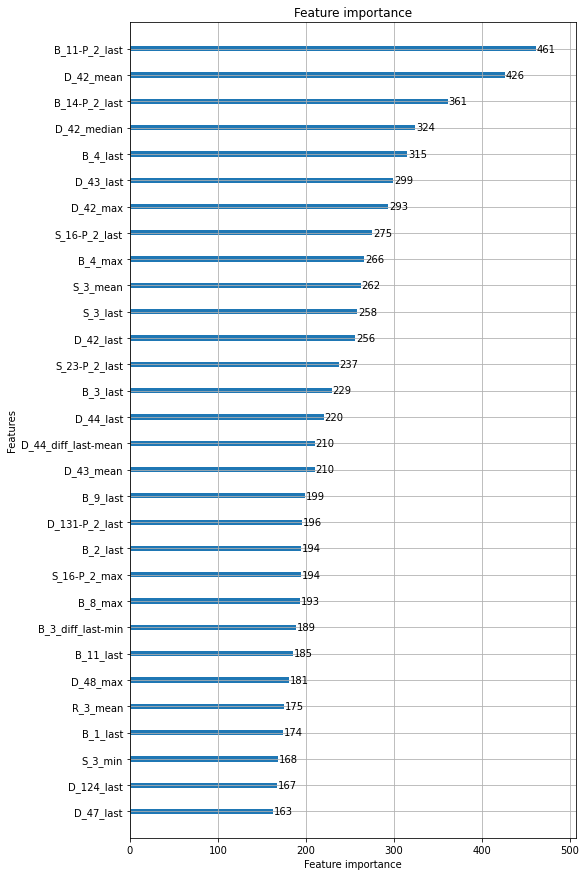

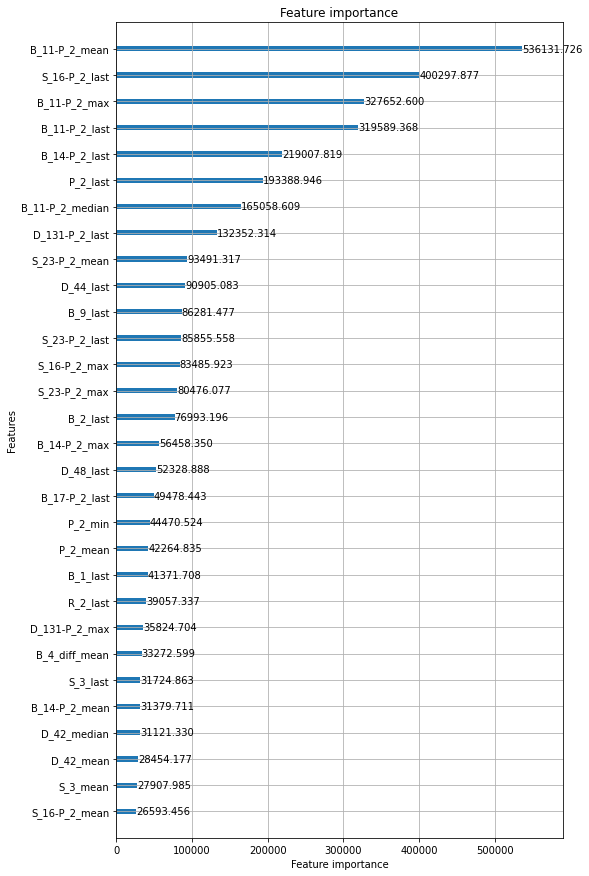

######################################## training model 2/5 ########################################


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.750286	valid_0's recall_at4: 0.601111	valid_0's norm_gini: 0.899462


[100]	valid_0's amex_metric: 0.762617	valid_0's recall_at4: 0.619793	valid_0's norm_gini: 0.905442


[150]	valid_0's amex_metric: 0.766413	valid_0's recall_at4: 0.623748	valid_0's norm_gini: 0.909078


[200]	valid_0's amex_metric: 0.773009	valid_0's recall_at4: 0.633384	valid_0's norm_gini: 0.912634


[250]	valid_0's amex_metric: 0.777946	valid_0's recall_at4: 0.640747	valid_0's norm_gini: 0.915145


[300]	valid_0's amex_metric: 0.781344	valid_0's recall_at4: 0.645923	valid_0's norm_gini: 0.916765


[350]	valid_0's amex_metric: 0.783432	valid_0's recall_at4: 0.648952	valid_0's norm_gini: 0.917911


[400]	valid_0's amex_metric: 0.785816	valid_0's recall_at4: 0.652781	valid_0's norm_gini: 0.918851


[450]	valid_0's amex_metric: 0.786544	valid_0's recall_at4: 0.653581	valid_0's norm_gini: 0.919508


[500]	valid_0's amex_metric: 0.78819	valid_0's recall_at4: 0.656316	valid_0's norm_gini: 0.920065


[550]	valid_0's amex_metric: 0.789851	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.920524


[600]	valid_0's amex_metric: 0.789391	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.920783


[650]	valid_0's amex_metric: 0.789639	valid_0's recall_at4: 0.658125	valid_0's norm_gini: 0.921153


[700]	valid_0's amex_metric: 0.790017	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.921488


[750]	valid_0's amex_metric: 0.790427	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.921761


[800]	valid_0's amex_metric: 0.79061	valid_0's recall_at4: 0.659261	valid_0's norm_gini: 0.92196


[850]	valid_0's amex_metric: 0.791261	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.922209


[900]	valid_0's amex_metric: 0.791212	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.922405


[950]	valid_0's amex_metric: 0.792065	valid_0's recall_at4: 0.661533	valid_0's norm_gini: 0.922596


[1000]	valid_0's amex_metric: 0.792015	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.922791


[1050]	valid_0's amex_metric: 0.792356	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.92301


[1100]	valid_0's amex_metric: 0.792665	valid_0's recall_at4: 0.662122	valid_0's norm_gini: 0.923208


[1150]	valid_0's amex_metric: 0.79274	valid_0's recall_at4: 0.662122	valid_0's norm_gini: 0.923358


[1200]	valid_0's amex_metric: 0.792558	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.923499


[1250]	valid_0's amex_metric: 0.792598	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.92362


[1300]	valid_0's amex_metric: 0.792776	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.923723


[1350]	valid_0's amex_metric: 0.793021	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.923793


[1400]	valid_0's amex_metric: 0.793297	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.923883


[1450]	valid_0's amex_metric: 0.793579	valid_0's recall_at4: 0.663216	valid_0's norm_gini: 0.923942


[1500]	valid_0's amex_metric: 0.793433	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.924071


[1550]	valid_0's amex_metric: 0.793502	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.924124


[1600]	valid_0's amex_metric: 0.794095	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.924174


[1650]	valid_0's amex_metric: 0.794359	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.92424


[1700]	valid_0's amex_metric: 0.794457	valid_0's recall_at4: 0.664647	valid_0's norm_gini: 0.924267


[1750]	valid_0's amex_metric: 0.794189	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.92432


[1800]	valid_0's amex_metric: 0.794239	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.924377


[1850]	valid_0's amex_metric: 0.794694	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924405


[1900]	valid_0's amex_metric: 0.794734	valid_0's recall_at4: 0.665026	valid_0's norm_gini: 0.924442


[1950]	valid_0's amex_metric: 0.795156	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924487


[2000]	valid_0's amex_metric: 0.795193	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924562


[2050]	valid_0's amex_metric: 0.795725	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.924614


[2100]	valid_0's amex_metric: 0.795852	valid_0's recall_at4: 0.667045	valid_0's norm_gini: 0.924659


[2150]	valid_0's amex_metric: 0.796097	valid_0's recall_at4: 0.667466	valid_0's norm_gini: 0.924728


[2200]	valid_0's amex_metric: 0.796423	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.924749


[2250]	valid_0's amex_metric: 0.796298	valid_0's recall_at4: 0.667845	valid_0's norm_gini: 0.924752


[2300]	valid_0's amex_metric: 0.796557	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.924764


[2350]	valid_0's amex_metric: 0.796616	valid_0's recall_at4: 0.668434	valid_0's norm_gini: 0.924798


[2400]	valid_0's amex_metric: 0.796274	valid_0's recall_at4: 0.667719	valid_0's norm_gini: 0.92483


[2450]	valid_0's amex_metric: 0.796481	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.924864


[2500]	valid_0's amex_metric: 0.796614	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.924878


[2550]	valid_0's amex_metric: 0.796245	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.924899


[2600]	valid_0's amex_metric: 0.796207	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924905


[2650]	valid_0's amex_metric: 0.796497	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.924898


[2700]	valid_0's amex_metric: 0.796337	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.924913


[2750]	valid_0's amex_metric: 0.796426	valid_0's recall_at4: 0.667929	valid_0's norm_gini: 0.924924


[2800]	valid_0's amex_metric: 0.796638	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.924927


[2850]	valid_0's amex_metric: 0.796345	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.924929


[2900]	valid_0's amex_metric: 0.79612	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.924942


[2950]	valid_0's amex_metric: 0.796284	valid_0's recall_at4: 0.667592	valid_0's norm_gini: 0.924975


[3000]	valid_0's amex_metric: 0.796834	valid_0's recall_at4: 0.668686	valid_0's norm_gini: 0.924982


[3050]	valid_0's amex_metric: 0.796487	valid_0's recall_at4: 0.667971	valid_0's norm_gini: 0.925002


[3100]	valid_0's amex_metric: 0.796379	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.924997


[3150]	valid_0's amex_metric: 0.796677	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925004


[3200]	valid_0's amex_metric: 0.796339	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.925001


[3250]	valid_0's amex_metric: 0.79668	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925011


[3300]	valid_0's amex_metric: 0.796956	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.925015


[3350]	valid_0's amex_metric: 0.796808	valid_0's recall_at4: 0.668602	valid_0's norm_gini: 0.925014


[3400]	valid_0's amex_metric: 0.796576	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.925012


[3450]	valid_0's amex_metric: 0.79663	valid_0's recall_at4: 0.668224	valid_0's norm_gini: 0.925036


[3500]	valid_0's amex_metric: 0.797054	valid_0's recall_at4: 0.669065	valid_0's norm_gini: 0.925044


[3550]	valid_0's amex_metric: 0.796781	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.925045


[3600]	valid_0's amex_metric: 0.796683	valid_0's recall_at4: 0.668308	valid_0's norm_gini: 0.925058


[3650]	valid_0's amex_metric: 0.796656	valid_0's recall_at4: 0.668266	valid_0's norm_gini: 0.925047


[3700]	valid_0's amex_metric: 0.796937	valid_0's recall_at4: 0.668813	valid_0's norm_gini: 0.925062


[3750]	valid_0's amex_metric: 0.796673	valid_0's recall_at4: 0.668308	valid_0's norm_gini: 0.925039


[3800]	valid_0's amex_metric: 0.796538	valid_0's recall_at4: 0.668055	valid_0's norm_gini: 0.925021


[3850]	valid_0's amex_metric: 0.796583	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.925026


[3900]	valid_0's amex_metric: 0.79677	valid_0's recall_at4: 0.668518	valid_0's norm_gini: 0.925022


[3950]	valid_0's amex_metric: 0.796897	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.925024


[4000]	valid_0's amex_metric: 0.797546	valid_0's recall_at4: 0.670075	valid_0's norm_gini: 0.925018


[4050]	valid_0's amex_metric: 0.79759	valid_0's recall_at4: 0.670159	valid_0's norm_gini: 0.925022


[4100]	valid_0's amex_metric: 0.797505	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.925019


[4150]	valid_0's amex_metric: 0.797361	valid_0's recall_at4: 0.669696	valid_0's norm_gini: 0.925026


[4200]	valid_0's amex_metric: 0.797108	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925024


[4250]	valid_0's amex_metric: 0.796917	valid_0's recall_at4: 0.668813	valid_0's norm_gini: 0.925021


[4300]	valid_0's amex_metric: 0.797283	valid_0's recall_at4: 0.669528	valid_0's norm_gini: 0.925039


[4350]	valid_0's amex_metric: 0.797079	valid_0's recall_at4: 0.669107	valid_0's norm_gini: 0.925051


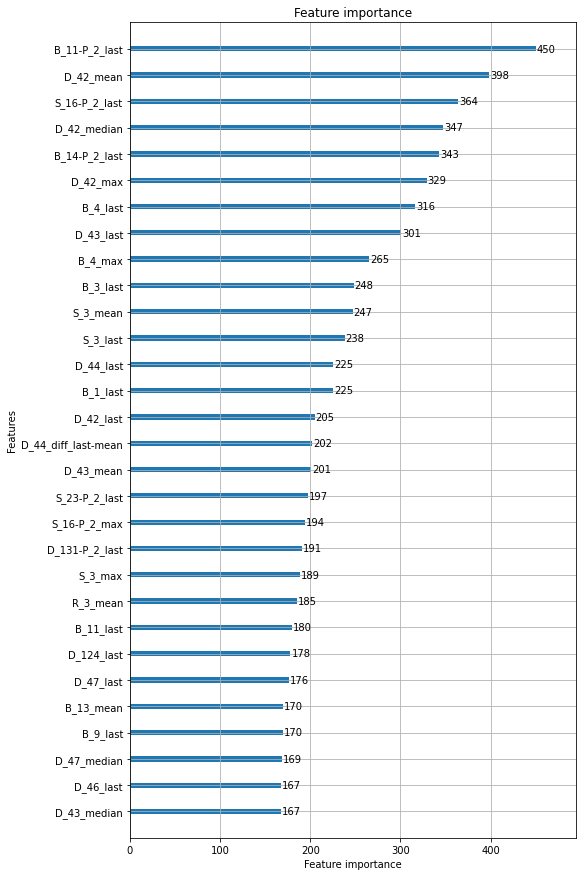

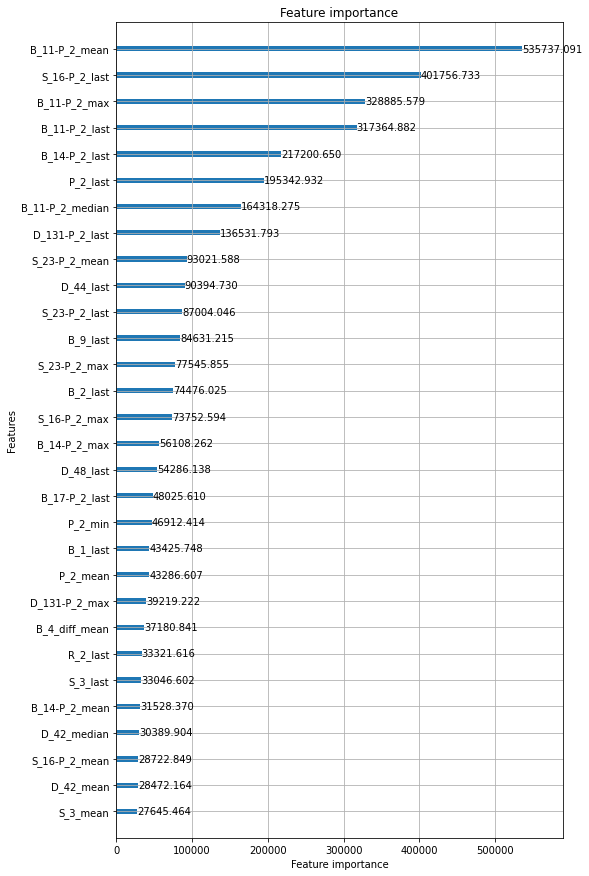

######################################## training model 3/5 ########################################


[50]	valid_0's amex_metric: 0.747352	valid_0's recall_at4: 0.595977	valid_0's norm_gini: 0.898726


[100]	valid_0's amex_metric: 0.757146	valid_0's recall_at4: 0.609779	valid_0's norm_gini: 0.904513


[150]	valid_0's amex_metric: 0.762592	valid_0's recall_at4: 0.617016	valid_0's norm_gini: 0.908168


[200]	valid_0's amex_metric: 0.76702	valid_0's recall_at4: 0.622444	valid_0's norm_gini: 0.911596


[250]	valid_0's amex_metric: 0.772603	valid_0's recall_at4: 0.631196	valid_0's norm_gini: 0.914009


[300]	valid_0's amex_metric: 0.775909	valid_0's recall_at4: 0.636329	valid_0's norm_gini: 0.915489


[350]	valid_0's amex_metric: 0.777585	valid_0's recall_at4: 0.638517	valid_0's norm_gini: 0.916652


[400]	valid_0's amex_metric: 0.779221	valid_0's recall_at4: 0.640831	valid_0's norm_gini: 0.91761


[450]	valid_0's amex_metric: 0.780711	valid_0's recall_at4: 0.643104	valid_0's norm_gini: 0.918318


[500]	valid_0's amex_metric: 0.781709	valid_0's recall_at4: 0.644576	valid_0's norm_gini: 0.918842


[550]	valid_0's amex_metric: 0.782216	valid_0's recall_at4: 0.645123	valid_0's norm_gini: 0.919308


[600]	valid_0's amex_metric: 0.783182	valid_0's recall_at4: 0.646764	valid_0's norm_gini: 0.9196


[650]	valid_0's amex_metric: 0.783886	valid_0's recall_at4: 0.647816	valid_0's norm_gini: 0.919955


[700]	valid_0's amex_metric: 0.784672	valid_0's recall_at4: 0.649121	valid_0's norm_gini: 0.920224


[750]	valid_0's amex_metric: 0.785285	valid_0's recall_at4: 0.65013	valid_0's norm_gini: 0.92044


[800]	valid_0's amex_metric: 0.785376	valid_0's recall_at4: 0.65013	valid_0's norm_gini: 0.920621


[850]	valid_0's amex_metric: 0.785829	valid_0's recall_at4: 0.650762	valid_0's norm_gini: 0.920896


[900]	valid_0's amex_metric: 0.786688	valid_0's recall_at4: 0.652318	valid_0's norm_gini: 0.921057


[950]	valid_0's amex_metric: 0.78763	valid_0's recall_at4: 0.653959	valid_0's norm_gini: 0.921302


[1000]	valid_0's amex_metric: 0.788054	valid_0's recall_at4: 0.654591	valid_0's norm_gini: 0.921518


[1050]	valid_0's amex_metric: 0.788221	valid_0's recall_at4: 0.654717	valid_0's norm_gini: 0.921726


[1100]	valid_0's amex_metric: 0.788523	valid_0's recall_at4: 0.655138	valid_0's norm_gini: 0.921908


[1150]	valid_0's amex_metric: 0.788812	valid_0's recall_at4: 0.655558	valid_0's norm_gini: 0.922066


[1200]	valid_0's amex_metric: 0.789311	valid_0's recall_at4: 0.656442	valid_0's norm_gini: 0.922179


[1250]	valid_0's amex_metric: 0.7901	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.922285


[1300]	valid_0's amex_metric: 0.78946	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.922352


[1350]	valid_0's amex_metric: 0.789817	valid_0's recall_at4: 0.657241	valid_0's norm_gini: 0.922393


[1400]	valid_0's amex_metric: 0.789112	valid_0's recall_at4: 0.655769	valid_0's norm_gini: 0.922456


[1450]	valid_0's amex_metric: 0.789489	valid_0's recall_at4: 0.656442	valid_0's norm_gini: 0.922536


[1500]	valid_0's amex_metric: 0.789587	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.922605


[1550]	valid_0's amex_metric: 0.789927	valid_0's recall_at4: 0.657199	valid_0's norm_gini: 0.922655


[1600]	valid_0's amex_metric: 0.790098	valid_0's recall_at4: 0.657494	valid_0's norm_gini: 0.922703


[1650]	valid_0's amex_metric: 0.790451	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.922734


[1700]	valid_0's amex_metric: 0.790839	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.922795


[1750]	valid_0's amex_metric: 0.790548	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.922845


[1800]	valid_0's amex_metric: 0.790338	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.922888


[1850]	valid_0's amex_metric: 0.790716	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.922928


[1900]	valid_0's amex_metric: 0.790897	valid_0's recall_at4: 0.65884	valid_0's norm_gini: 0.922954


[1950]	valid_0's amex_metric: 0.790765	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.922984


[2000]	valid_0's amex_metric: 0.790645	valid_0's recall_at4: 0.658293	valid_0's norm_gini: 0.922997


[2050]	valid_0's amex_metric: 0.791109	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.923042


[2100]	valid_0's amex_metric: 0.791098	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.923103


[2150]	valid_0's amex_metric: 0.790775	valid_0's recall_at4: 0.65842	valid_0's norm_gini: 0.923131


[2200]	valid_0's amex_metric: 0.790619	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.923155


[2250]	valid_0's amex_metric: 0.790762	valid_0's recall_at4: 0.658335	valid_0's norm_gini: 0.923189


[2300]	valid_0's amex_metric: 0.790902	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.923215


[2350]	valid_0's amex_metric: 0.790651	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.923218


[2400]	valid_0's amex_metric: 0.790741	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.92323


[2450]	valid_0's amex_metric: 0.790383	valid_0's recall_at4: 0.657536	valid_0's norm_gini: 0.92323


[2500]	valid_0's amex_metric: 0.790891	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.923235


[2550]	valid_0's amex_metric: 0.790396	valid_0's recall_at4: 0.657536	valid_0's norm_gini: 0.923256


[2600]	valid_0's amex_metric: 0.79029	valid_0's recall_at4: 0.657326	valid_0's norm_gini: 0.923253


[2650]	valid_0's amex_metric: 0.790675	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.923268


[2700]	valid_0's amex_metric: 0.791186	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.92328


[2750]	valid_0's amex_metric: 0.791405	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.923297


[2800]	valid_0's amex_metric: 0.791504	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.923325


[2850]	valid_0's amex_metric: 0.791507	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.923333


[2900]	valid_0's amex_metric: 0.791627	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.923319


[2950]	valid_0's amex_metric: 0.791711	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.923319


[3000]	valid_0's amex_metric: 0.79146	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.923322


[3050]	valid_0's amex_metric: 0.7915	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.923359


[3100]	valid_0's amex_metric: 0.792386	valid_0's recall_at4: 0.661407	valid_0's norm_gini: 0.923365


[3150]	valid_0's amex_metric: 0.791868	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.923382


[3200]	valid_0's amex_metric: 0.791671	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.923366


[3250]	valid_0's amex_metric: 0.791671	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.923367


[3300]	valid_0's amex_metric: 0.792213	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.923356


[3350]	valid_0's amex_metric: 0.791825	valid_0's recall_at4: 0.660271	valid_0's norm_gini: 0.923379


[3400]	valid_0's amex_metric: 0.792313	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.923386


[3450]	valid_0's amex_metric: 0.792189	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.923392


[3500]	valid_0's amex_metric: 0.792368	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.923371


[3550]	valid_0's amex_metric: 0.792254	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.923396


[3600]	valid_0's amex_metric: 0.792463	valid_0's recall_at4: 0.661533	valid_0's norm_gini: 0.923393


[3650]	valid_0's amex_metric: 0.792239	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.923408


[3700]	valid_0's amex_metric: 0.792391	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.923417


[3750]	valid_0's amex_metric: 0.791696	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.923416


[3800]	valid_0's amex_metric: 0.791871	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.92343


[3850]	valid_0's amex_metric: 0.792108	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.92344


[3900]	valid_0's amex_metric: 0.792088	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.923443


[3950]	valid_0's amex_metric: 0.792358	valid_0's recall_at4: 0.661281	valid_0's norm_gini: 0.923434


[4000]	valid_0's amex_metric: 0.792342	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.923445


[4050]	valid_0's amex_metric: 0.792577	valid_0's recall_at4: 0.661702	valid_0's norm_gini: 0.923452


[4100]	valid_0's amex_metric: 0.792534	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.923451


[4150]	valid_0's amex_metric: 0.792359	valid_0's recall_at4: 0.661239	valid_0's norm_gini: 0.923478


[4200]	valid_0's amex_metric: 0.791953	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.923466


[4250]	valid_0's amex_metric: 0.792095	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.923456


[4300]	valid_0's amex_metric: 0.791917	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.923437


[4350]	valid_0's amex_metric: 0.792529	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.923441


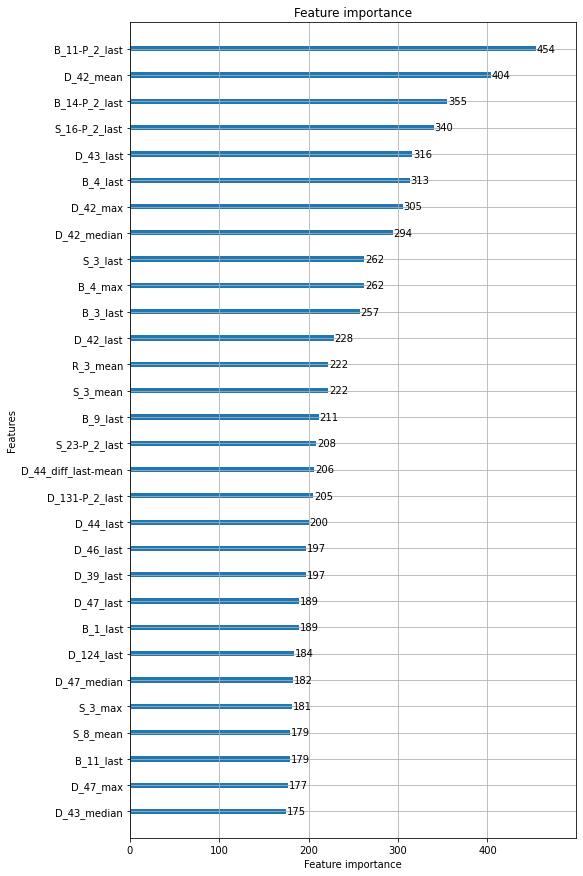

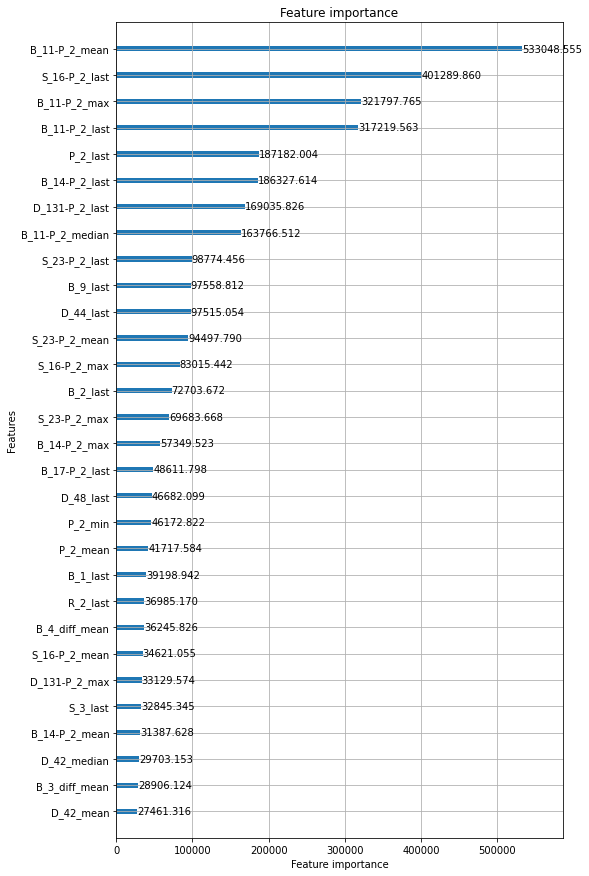

######################################## training model 4/5 ########################################


[50]	valid_0's amex_metric: 0.744593	valid_0's recall_at4: 0.591248	valid_0's norm_gini: 0.897939


[100]	valid_0's amex_metric: 0.756306	valid_0's recall_at4: 0.608668	valid_0's norm_gini: 0.903944


[150]	valid_0's amex_metric: 0.762115	valid_0's recall_at4: 0.616621	valid_0's norm_gini: 0.90761


[200]	valid_0's amex_metric: 0.767453	valid_0's recall_at4: 0.62369	valid_0's norm_gini: 0.911215


[250]	valid_0's amex_metric: 0.773094	valid_0's recall_at4: 0.632316	valid_0's norm_gini: 0.913871


[300]	valid_0's amex_metric: 0.77526	valid_0's recall_at4: 0.634967	valid_0's norm_gini: 0.915552


[350]	valid_0's amex_metric: 0.776978	valid_0's recall_at4: 0.637198	valid_0's norm_gini: 0.916759


[400]	valid_0's amex_metric: 0.778711	valid_0's recall_at4: 0.63968	valid_0's norm_gini: 0.917743


[450]	valid_0's amex_metric: 0.780087	valid_0's recall_at4: 0.6417	valid_0's norm_gini: 0.918473


[500]	valid_0's amex_metric: 0.781419	valid_0's recall_at4: 0.643762	valid_0's norm_gini: 0.919077


[550]	valid_0's amex_metric: 0.783005	valid_0's recall_at4: 0.646455	valid_0's norm_gini: 0.919555


[600]	valid_0's amex_metric: 0.783436	valid_0's recall_at4: 0.647002	valid_0's norm_gini: 0.91987


[650]	valid_0's amex_metric: 0.784205	valid_0's recall_at4: 0.64818	valid_0's norm_gini: 0.92023


[700]	valid_0's amex_metric: 0.785383	valid_0's recall_at4: 0.6502	valid_0's norm_gini: 0.920565


[750]	valid_0's amex_metric: 0.785775	valid_0's recall_at4: 0.650705	valid_0's norm_gini: 0.920845


[800]	valid_0's amex_metric: 0.786188	valid_0's recall_at4: 0.651336	valid_0's norm_gini: 0.921041


[850]	valid_0's amex_metric: 0.786885	valid_0's recall_at4: 0.652472	valid_0's norm_gini: 0.921298


[900]	valid_0's amex_metric: 0.786545	valid_0's recall_at4: 0.651588	valid_0's norm_gini: 0.921501


[950]	valid_0's amex_metric: 0.787523	valid_0's recall_at4: 0.653272	valid_0's norm_gini: 0.921774


[1000]	valid_0's amex_metric: 0.787379	valid_0's recall_at4: 0.652767	valid_0's norm_gini: 0.921991


[1050]	valid_0's amex_metric: 0.788032	valid_0's recall_at4: 0.653861	valid_0's norm_gini: 0.922203


[1100]	valid_0's amex_metric: 0.788665	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.922418


[1150]	valid_0's amex_metric: 0.78871	valid_0's recall_at4: 0.654829	valid_0's norm_gini: 0.922592


[1200]	valid_0's amex_metric: 0.788499	valid_0's recall_at4: 0.654239	valid_0's norm_gini: 0.922758


[1250]	valid_0's amex_metric: 0.788384	valid_0's recall_at4: 0.653903	valid_0's norm_gini: 0.922865


[1300]	valid_0's amex_metric: 0.788859	valid_0's recall_at4: 0.654786	valid_0's norm_gini: 0.922931


[1350]	valid_0's amex_metric: 0.789095	valid_0's recall_at4: 0.655165	valid_0's norm_gini: 0.923025


[1400]	valid_0's amex_metric: 0.78962	valid_0's recall_at4: 0.656133	valid_0's norm_gini: 0.923108


[1450]	valid_0's amex_metric: 0.789695	valid_0's recall_at4: 0.656217	valid_0's norm_gini: 0.923172


[1500]	valid_0's amex_metric: 0.790004	valid_0's recall_at4: 0.656764	valid_0's norm_gini: 0.923243


[1550]	valid_0's amex_metric: 0.790391	valid_0's recall_at4: 0.657437	valid_0's norm_gini: 0.923344


[1600]	valid_0's amex_metric: 0.790504	valid_0's recall_at4: 0.657648	valid_0's norm_gini: 0.92336


[1650]	valid_0's amex_metric: 0.790563	valid_0's recall_at4: 0.65769	valid_0's norm_gini: 0.923437


[1700]	valid_0's amex_metric: 0.79004	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.923484


[1750]	valid_0's amex_metric: 0.790579	valid_0's recall_at4: 0.657606	valid_0's norm_gini: 0.923552


[1800]	valid_0's amex_metric: 0.790139	valid_0's recall_at4: 0.65668	valid_0's norm_gini: 0.923598


[1850]	valid_0's amex_metric: 0.789991	valid_0's recall_at4: 0.656343	valid_0's norm_gini: 0.923638


[1900]	valid_0's amex_metric: 0.790235	valid_0's recall_at4: 0.656806	valid_0's norm_gini: 0.923664


[1950]	valid_0's amex_metric: 0.790052	valid_0's recall_at4: 0.656385	valid_0's norm_gini: 0.923718


[2000]	valid_0's amex_metric: 0.790772	valid_0's recall_at4: 0.657816	valid_0's norm_gini: 0.923728


[2050]	valid_0's amex_metric: 0.790891	valid_0's recall_at4: 0.658027	valid_0's norm_gini: 0.923755


[2100]	valid_0's amex_metric: 0.790898	valid_0's recall_at4: 0.658027	valid_0's norm_gini: 0.923769


[2150]	valid_0's amex_metric: 0.790932	valid_0's recall_at4: 0.658069	valid_0's norm_gini: 0.923795


[2200]	valid_0's amex_metric: 0.791059	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.923838


[2250]	valid_0's amex_metric: 0.791487	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.923854


[2300]	valid_0's amex_metric: 0.790891	valid_0's recall_at4: 0.6579	valid_0's norm_gini: 0.923883


[2350]	valid_0's amex_metric: 0.791349	valid_0's recall_at4: 0.658784	valid_0's norm_gini: 0.923915


[2400]	valid_0's amex_metric: 0.791748	valid_0's recall_at4: 0.659541	valid_0's norm_gini: 0.923956


[2450]	valid_0's amex_metric: 0.791542	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.923963


[2500]	valid_0's amex_metric: 0.79185	valid_0's recall_at4: 0.65971	valid_0's norm_gini: 0.92399


[2550]	valid_0's amex_metric: 0.791405	valid_0's recall_at4: 0.658826	valid_0's norm_gini: 0.923984


[2600]	valid_0's amex_metric: 0.791683	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.923992


[2650]	valid_0's amex_metric: 0.791534	valid_0's recall_at4: 0.659078	valid_0's norm_gini: 0.923989


[2700]	valid_0's amex_metric: 0.792008	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.924012


[2750]	valid_0's amex_metric: 0.791705	valid_0's recall_at4: 0.659415	valid_0's norm_gini: 0.923994


[2800]	valid_0's amex_metric: 0.791653	valid_0's recall_at4: 0.659289	valid_0's norm_gini: 0.924018


[2850]	valid_0's amex_metric: 0.792185	valid_0's recall_at4: 0.660341	valid_0's norm_gini: 0.92403


[2900]	valid_0's amex_metric: 0.792152	valid_0's recall_at4: 0.660257	valid_0's norm_gini: 0.924048


[2950]	valid_0's amex_metric: 0.791742	valid_0's recall_at4: 0.659415	valid_0's norm_gini: 0.924069


[3000]	valid_0's amex_metric: 0.791964	valid_0's recall_at4: 0.659878	valid_0's norm_gini: 0.924051


[3050]	valid_0's amex_metric: 0.791804	valid_0's recall_at4: 0.659541	valid_0's norm_gini: 0.924067


[3100]	valid_0's amex_metric: 0.791599	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.924077


[3150]	valid_0's amex_metric: 0.79192	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.924089


[3200]	valid_0's amex_metric: 0.791932	valid_0's recall_at4: 0.659752	valid_0's norm_gini: 0.924112


[3250]	valid_0's amex_metric: 0.791546	valid_0's recall_at4: 0.658994	valid_0's norm_gini: 0.924097


[3300]	valid_0's amex_metric: 0.791663	valid_0's recall_at4: 0.659247	valid_0's norm_gini: 0.924078


[3350]	valid_0's amex_metric: 0.79159	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.92406


[3400]	valid_0's amex_metric: 0.791252	valid_0's recall_at4: 0.658447	valid_0's norm_gini: 0.924057


[3450]	valid_0's amex_metric: 0.791296	valid_0's recall_at4: 0.658531	valid_0's norm_gini: 0.924061


[3500]	valid_0's amex_metric: 0.791721	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.924069


[3550]	valid_0's amex_metric: 0.79227	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.924073


[3600]	valid_0's amex_metric: 0.792504	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.924079


[3650]	valid_0's amex_metric: 0.792363	valid_0's recall_at4: 0.660635	valid_0's norm_gini: 0.924092


[3700]	valid_0's amex_metric: 0.792316	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.924123


[3750]	valid_0's amex_metric: 0.792611	valid_0's recall_at4: 0.661098	valid_0's norm_gini: 0.924125


[3800]	valid_0's amex_metric: 0.792712	valid_0's recall_at4: 0.661309	valid_0's norm_gini: 0.924116


[3850]	valid_0's amex_metric: 0.792872	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.924099


[3900]	valid_0's amex_metric: 0.792857	valid_0's recall_at4: 0.661603	valid_0's norm_gini: 0.92411


[3950]	valid_0's amex_metric: 0.792775	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.924114


[4000]	valid_0's amex_metric: 0.792646	valid_0's recall_at4: 0.661182	valid_0's norm_gini: 0.924109


[4050]	valid_0's amex_metric: 0.792151	valid_0's recall_at4: 0.660215	valid_0's norm_gini: 0.924088


[4100]	valid_0's amex_metric: 0.791891	valid_0's recall_at4: 0.65971	valid_0's norm_gini: 0.924073


[4150]	valid_0's amex_metric: 0.792447	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924091


[4200]	valid_0's amex_metric: 0.792095	valid_0's recall_at4: 0.660088	valid_0's norm_gini: 0.924101


[4250]	valid_0's amex_metric: 0.792039	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924115


[4300]	valid_0's amex_metric: 0.792468	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924133


[4350]	valid_0's amex_metric: 0.792214	valid_0's recall_at4: 0.660299	valid_0's norm_gini: 0.92413


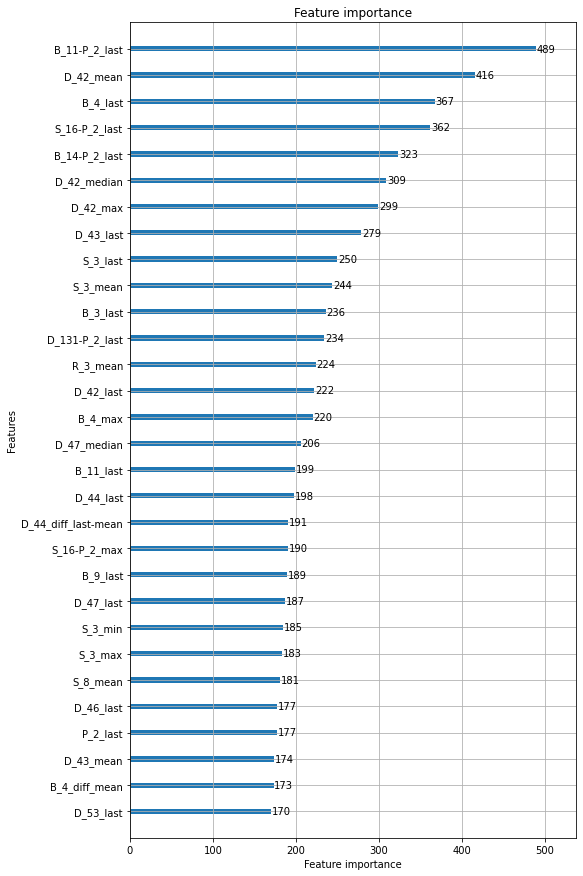

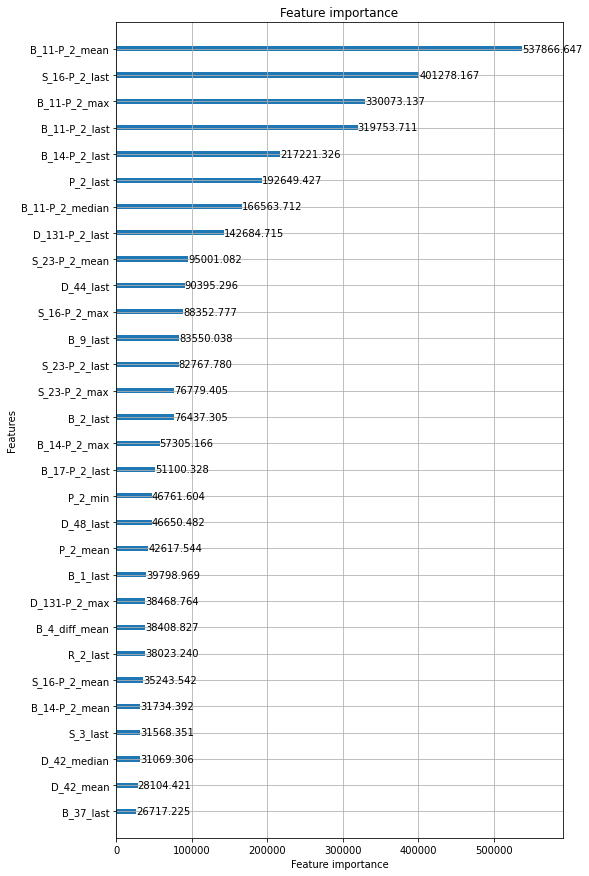

######################################## training model 5/5 ########################################


[50]	valid_0's amex_metric: 0.756069	valid_0's recall_at4: 0.610309	valid_0's norm_gini: 0.901829


[100]	valid_0's amex_metric: 0.765389	valid_0's recall_at4: 0.623143	valid_0's norm_gini: 0.907634


[150]	valid_0's amex_metric: 0.770395	valid_0's recall_at4: 0.629455	valid_0's norm_gini: 0.911335


[200]	valid_0's amex_metric: 0.777522	valid_0's recall_at4: 0.639975	valid_0's norm_gini: 0.915068


[250]	valid_0's amex_metric: 0.781557	valid_0's recall_at4: 0.645655	valid_0's norm_gini: 0.917458


[300]	valid_0's amex_metric: 0.784273	valid_0's recall_at4: 0.6494	valid_0's norm_gini: 0.919147


[350]	valid_0's amex_metric: 0.78625	valid_0's recall_at4: 0.652178	valid_0's norm_gini: 0.920322


[400]	valid_0's amex_metric: 0.788516	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.921278


[450]	valid_0's amex_metric: 0.790115	valid_0's recall_at4: 0.658237	valid_0's norm_gini: 0.921993


[500]	valid_0's amex_metric: 0.791736	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.922542


[550]	valid_0's amex_metric: 0.792486	valid_0's recall_at4: 0.661982	valid_0's norm_gini: 0.922991


[600]	valid_0's amex_metric: 0.792871	valid_0's recall_at4: 0.662445	valid_0's norm_gini: 0.923298


[650]	valid_0's amex_metric: 0.793898	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.923626


[700]	valid_0's amex_metric: 0.795116	valid_0's recall_at4: 0.666316	valid_0's norm_gini: 0.923915


[750]	valid_0's amex_metric: 0.795092	valid_0's recall_at4: 0.666021	valid_0's norm_gini: 0.924162


[800]	valid_0's amex_metric: 0.79594	valid_0's recall_at4: 0.667494	valid_0's norm_gini: 0.924386


[850]	valid_0's amex_metric: 0.795699	valid_0's recall_at4: 0.666737	valid_0's norm_gini: 0.924662


[900]	valid_0's amex_metric: 0.796771	valid_0's recall_at4: 0.668715	valid_0's norm_gini: 0.924827


[950]	valid_0's amex_metric: 0.797156	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925092


[1000]	valid_0's amex_metric: 0.79751	valid_0's recall_at4: 0.669724	valid_0's norm_gini: 0.925295


[1050]	valid_0's amex_metric: 0.798182	valid_0's recall_at4: 0.670861	valid_0's norm_gini: 0.925504


[1100]	valid_0's amex_metric: 0.798637	valid_0's recall_at4: 0.671576	valid_0's norm_gini: 0.925698


[1150]	valid_0's amex_metric: 0.79885	valid_0's recall_at4: 0.67187	valid_0's norm_gini: 0.92583


[1200]	valid_0's amex_metric: 0.79919	valid_0's recall_at4: 0.672417	valid_0's norm_gini: 0.925963


[1250]	valid_0's amex_metric: 0.799145	valid_0's recall_at4: 0.672207	valid_0's norm_gini: 0.926082


[1300]	valid_0's amex_metric: 0.799615	valid_0's recall_at4: 0.673049	valid_0's norm_gini: 0.926181


[1350]	valid_0's amex_metric: 0.799646	valid_0's recall_at4: 0.673049	valid_0's norm_gini: 0.926243


[1400]	valid_0's amex_metric: 0.799607	valid_0's recall_at4: 0.67288	valid_0's norm_gini: 0.926333


[1450]	valid_0's amex_metric: 0.800051	valid_0's recall_at4: 0.67368	valid_0's norm_gini: 0.926422


[1500]	valid_0's amex_metric: 0.800102	valid_0's recall_at4: 0.67368	valid_0's norm_gini: 0.926524


[1550]	valid_0's amex_metric: 0.800865	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.92662


[1600]	valid_0's amex_metric: 0.800555	valid_0's recall_at4: 0.674437	valid_0's norm_gini: 0.926672


[1650]	valid_0's amex_metric: 0.800397	valid_0's recall_at4: 0.674058	valid_0's norm_gini: 0.926736


[1700]	valid_0's amex_metric: 0.80037	valid_0's recall_at4: 0.673974	valid_0's norm_gini: 0.926766


[1750]	valid_0's amex_metric: 0.800171	valid_0's recall_at4: 0.673511	valid_0's norm_gini: 0.92683


[1800]	valid_0's amex_metric: 0.800303	valid_0's recall_at4: 0.673764	valid_0's norm_gini: 0.926842


[1850]	valid_0's amex_metric: 0.800777	valid_0's recall_at4: 0.674648	valid_0's norm_gini: 0.926906


[1900]	valid_0's amex_metric: 0.801023	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.926935


[1950]	valid_0's amex_metric: 0.801003	valid_0's recall_at4: 0.675026	valid_0's norm_gini: 0.926979


[2000]	valid_0's amex_metric: 0.801166	valid_0's recall_at4: 0.675321	valid_0's norm_gini: 0.92701


[2050]	valid_0's amex_metric: 0.800967	valid_0's recall_at4: 0.6749	valid_0's norm_gini: 0.927034


[2100]	valid_0's amex_metric: 0.801066	valid_0's recall_at4: 0.675068	valid_0's norm_gini: 0.927063


[2150]	valid_0's amex_metric: 0.800875	valid_0's recall_at4: 0.674648	valid_0's norm_gini: 0.927103


[2200]	valid_0's amex_metric: 0.801481	valid_0's recall_at4: 0.675826	valid_0's norm_gini: 0.927137


[2250]	valid_0's amex_metric: 0.801469	valid_0's recall_at4: 0.675784	valid_0's norm_gini: 0.927155


[2300]	valid_0's amex_metric: 0.801143	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.927175


[2350]	valid_0's amex_metric: 0.801852	valid_0's recall_at4: 0.676499	valid_0's norm_gini: 0.927206


[2400]	valid_0's amex_metric: 0.802264	valid_0's recall_at4: 0.677299	valid_0's norm_gini: 0.927229


[2450]	valid_0's amex_metric: 0.801727	valid_0's recall_at4: 0.676205	valid_0's norm_gini: 0.927249


[2500]	valid_0's amex_metric: 0.802035	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927277


[2550]	valid_0's amex_metric: 0.801876	valid_0's recall_at4: 0.676457	valid_0's norm_gini: 0.927296


[2600]	valid_0's amex_metric: 0.80205	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927306


[2650]	valid_0's amex_metric: 0.80201	valid_0's recall_at4: 0.676709	valid_0's norm_gini: 0.92731


[2700]	valid_0's amex_metric: 0.802049	valid_0's recall_at4: 0.676752	valid_0's norm_gini: 0.927346


[2750]	valid_0's amex_metric: 0.802028	valid_0's recall_at4: 0.676709	valid_0's norm_gini: 0.927346


[2800]	valid_0's amex_metric: 0.802055	valid_0's recall_at4: 0.676752	valid_0's norm_gini: 0.927359


[2850]	valid_0's amex_metric: 0.801751	valid_0's recall_at4: 0.67612	valid_0's norm_gini: 0.927382


[2900]	valid_0's amex_metric: 0.801571	valid_0's recall_at4: 0.675742	valid_0's norm_gini: 0.927401


[2950]	valid_0's amex_metric: 0.802199	valid_0's recall_at4: 0.676962	valid_0's norm_gini: 0.927437


[3000]	valid_0's amex_metric: 0.802091	valid_0's recall_at4: 0.676752	valid_0's norm_gini: 0.927431


[3050]	valid_0's amex_metric: 0.802091	valid_0's recall_at4: 0.676752	valid_0's norm_gini: 0.927431


[3100]	valid_0's amex_metric: 0.802028	valid_0's recall_at4: 0.676625	valid_0's norm_gini: 0.927431


[3150]	valid_0's amex_metric: 0.802505	valid_0's recall_at4: 0.677593	valid_0's norm_gini: 0.927418


[3200]	valid_0's amex_metric: 0.802175	valid_0's recall_at4: 0.67692	valid_0's norm_gini: 0.927429


[3250]	valid_0's amex_metric: 0.80222	valid_0's recall_at4: 0.677004	valid_0's norm_gini: 0.927437


[3300]	valid_0's amex_metric: 0.80208	valid_0's recall_at4: 0.676709	valid_0's norm_gini: 0.927451


[3350]	valid_0's amex_metric: 0.802203	valid_0's recall_at4: 0.676962	valid_0's norm_gini: 0.927443


[3400]	valid_0's amex_metric: 0.802738	valid_0's recall_at4: 0.678014	valid_0's norm_gini: 0.927462


[3450]	valid_0's amex_metric: 0.8025	valid_0's recall_at4: 0.677509	valid_0's norm_gini: 0.92749


[3500]	valid_0's amex_metric: 0.802327	valid_0's recall_at4: 0.677172	valid_0's norm_gini: 0.927483


[3550]	valid_0's amex_metric: 0.80261	valid_0's recall_at4: 0.677719	valid_0's norm_gini: 0.9275


[3600]	valid_0's amex_metric: 0.802907	valid_0's recall_at4: 0.678308	valid_0's norm_gini: 0.927505


[3650]	valid_0's amex_metric: 0.802529	valid_0's recall_at4: 0.677551	valid_0's norm_gini: 0.927508


[3700]	valid_0's amex_metric: 0.80251	valid_0's recall_at4: 0.677509	valid_0's norm_gini: 0.927511


[3750]	valid_0's amex_metric: 0.802465	valid_0's recall_at4: 0.677425	valid_0's norm_gini: 0.927505


[3800]	valid_0's amex_metric: 0.802459	valid_0's recall_at4: 0.677425	valid_0's norm_gini: 0.927494


[3850]	valid_0's amex_metric: 0.802737	valid_0's recall_at4: 0.677972	valid_0's norm_gini: 0.927502


[3900]	valid_0's amex_metric: 0.802605	valid_0's recall_at4: 0.677719	valid_0's norm_gini: 0.927491


[3950]	valid_0's amex_metric: 0.803032	valid_0's recall_at4: 0.678561	valid_0's norm_gini: 0.927502


[4000]	valid_0's amex_metric: 0.802986	valid_0's recall_at4: 0.678477	valid_0's norm_gini: 0.927496


[4050]	valid_0's amex_metric: 0.802652	valid_0's recall_at4: 0.677804	valid_0's norm_gini: 0.927501


[4100]	valid_0's amex_metric: 0.802562	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.927488


[4150]	valid_0's amex_metric: 0.802689	valid_0's recall_at4: 0.677888	valid_0's norm_gini: 0.927491


[4200]	valid_0's amex_metric: 0.802594	valid_0's recall_at4: 0.677677	valid_0's norm_gini: 0.927511


[4250]	valid_0's amex_metric: 0.802932	valid_0's recall_at4: 0.678351	valid_0's norm_gini: 0.927514


[4300]	valid_0's amex_metric: 0.802569	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.927503


[4350]	valid_0's amex_metric: 0.802745	valid_0's recall_at4: 0.677972	valid_0's norm_gini: 0.927519


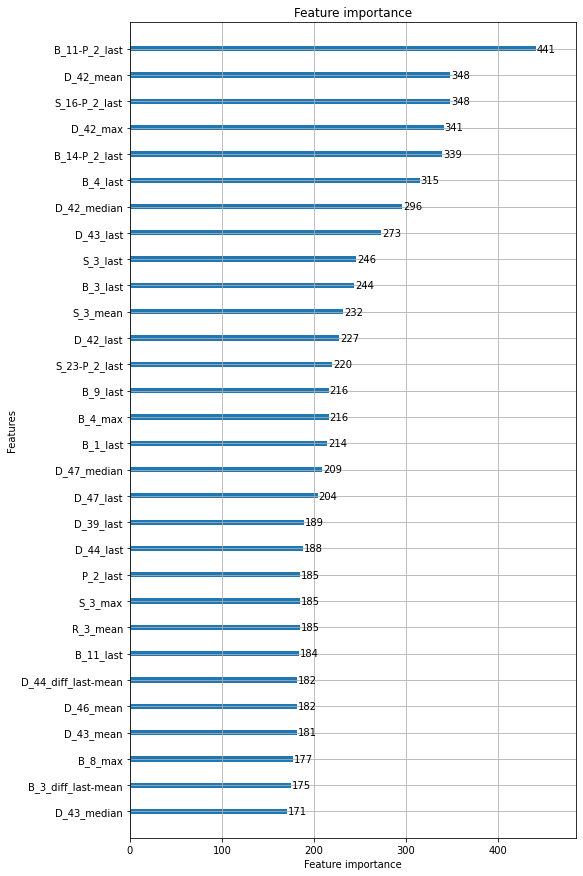

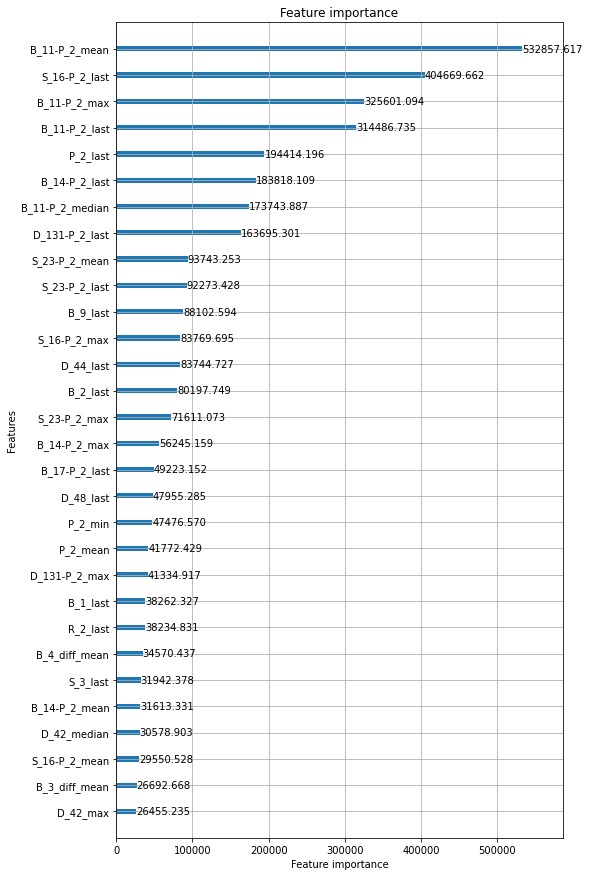

Training time: 33.591834366321564 min.


OOF recall_at4: 0.6673342983135288


OOF normalized_gini: 0.9250004680226668


OOF competition metric: 0.7961673831680978


CPU times: user 12h 2min 45s, sys: 41.1 s, total: 12h 3min 26s
Wall time: 33min 41s


In [11]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_models.append(models)
    all_oof_dfs.append(oof)
    
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"/model-cv{repetition}-fold{fold}.txt")
          
    del _train, folds; gc.collect()

In [12]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

,recall_at4,gini,metric
0,0.667334,0.925,0.796167



mean:


recall_at4    0.667334
gini          0.925000
metric        0.796167
dtype: float64


std:


recall_at4   NaN
gini         NaN
metric       NaN
dtype: float64

In [13]:
del train
gc.collect()

21

***
## make predictions and submit

In [14]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)    

In [15]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [16]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

CPU times: user 36min 15s, sys: 20.1 s, total: 36min 35s
Wall time: 1min 53s


In [17]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.52 s, sys: 978 ms, total: 4.5 s
Wall time: 4.63 s


***